In [2]:
from VAE_model import build_model, pack, unpack
import glob
import numpy as np
from tqdm import tqdm
from lucid.misc.io import load
from lucid.optvis.param import cppn
from lucid.optvis import objectives
from lucid.optvis import render
from lucid.misc.tfutil import create_session
import tensorflow as tf
from lucid.modelzoo import vision_models
import pylab as plt

In [3]:
cutoff = 128**10
image_size = 400
size_n = 200
F_MODELS = glob.glob("results/VAE_base_models/*.npy")[:cutoff]

In [4]:
# Load the save model params
params0 = [load(f_model) for f_model in tqdm(F_MODELS)]
shapes = list(map(lambda x:x.shape, params0[0]))
X = np.array([unpack(p) for p in params0])

100%|██████████| 79/79 [00:00<00:00, 86.13it/s]


In [5]:
class render_model():
    def __init__(self):

        print ("Loading Inception model")
        self.model = vision_models.InceptionV1()
        self.model.load_graphdef()

        sess = create_session()

        self.t_size = tf.placeholder_with_default(size_n, [])
        obj = objectives.channel("mixed4a", 0)
        self.T = render.make_vis_T(
            self.model, obj,
            param_f=lambda: cppn(self.t_size),
        )

        tf.global_variables_initializer().run()
        self.train_vars = sess.graph.get_collection(
            tf.GraphKeys.TRAINABLE_VARIABLES)

    def __call__(self, params):

        feed_dict = dict(zip(self.train_vars, params))
        feed_dict[self.t_size] = image_size
        return self.T("input").eval(feed_dict)[0]


In [6]:
R = render_model()

Loading Inception model


In [10]:
latent_n = 12
intermediate_n = 512
input_n = 8451
f_h5 = 'results/VAE_weights.h5'

VAE, encoder, decoder = build_model(
    input_n, intermediate_n, latent_n)
VAE = VAE.load_weights(f_h5)

z_mean, z_std_log, Z = encoder.predict(X, batch_size=128)
XR = decoder.predict(z)

In [63]:
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['figure.figsize'] = [16, 14]
mpl.rc('axes',facecolor=(1,1,1,0),edgecolor=(1,1,1,0));
mpl.rc(('xtick','ytick'),color=(1,1,1,0));
mpl.rc('axes.spines',top=False,bottom=False,left=False,right=False);

16it [00:00, 34.24it/s]


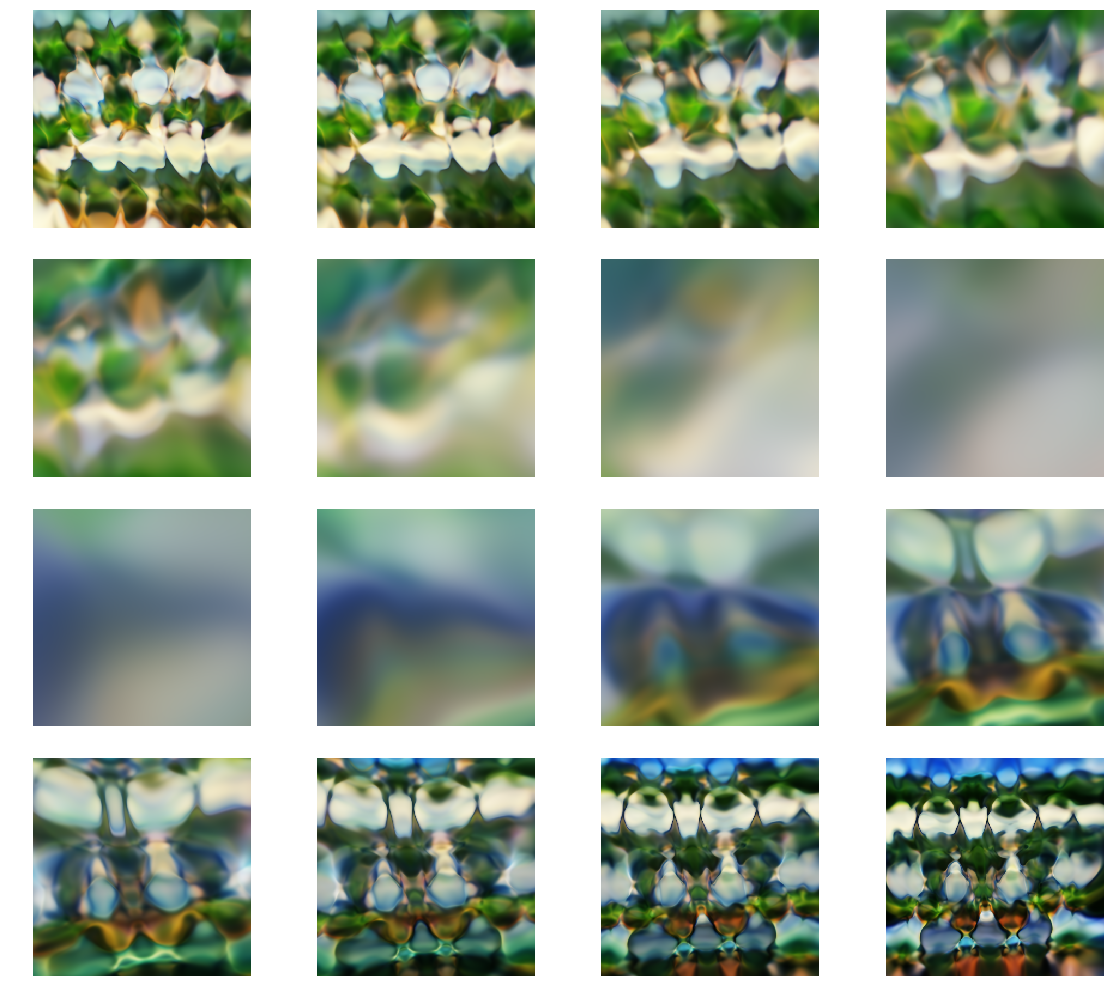

In [74]:
z0 = Z[7].reshape(1,-1)
z1 = Z[19].reshape(1,-1)

f, axes = plt.subplots(4, 4)
axes = axes.ravel()

for ax,p in tqdm(zip(axes,np.linspace(0,1,16))):
    lz = (1-p)*z0+p*z1
    img = R(pack(decoder.predict(lz)[0], shapes))
    ax.imshow(img)

plt.tight_layout()
plt.show()